## Image Captioning with Pytorch

The following contents are modified from MDS DSCI 575 lecture 8 demo

In [0]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

from nltk.translate import bleu_score

START = "startseq"
STOP = "endseq"
EPOCHS = 10


In [0]:
# torch.cuda.empty_cache()
# import gc 
# model = None
# gc.collect()

The following function is used to nicely format elapsed times.

In [0]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Google CoLab

If you are using Google CoLab then you will need to execute this cell.

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root_captioning = "/content/drive/My Drive/data"
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


### Clean/Build Dataset

- Read captions
- Preprocess captions


In [0]:

set_names = ['rsicd', 'ucm', 'sydney']

def get_img_info(name, num):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    num: int
        the number of observations to get

    Return:
    --------
    list, dict, int
        img paths, corresponding captions, max length of captions
    """
    img_path = []
    caption = [] 
    max_length = 0
    with open(root_captioning + '/processed/' + name + '.json', 'r') as json_data:
        data = json.load(json_data)
        for set_name in set_names:
            for filename in data[set_name].keys():
                if len(caption) == num:
                    break

                img_path.append(root_captioning + '/raw/imgs/'+ set_name + '/' + filename)
                sen_list = []
                for sentence in data[set_name][filename]['sentences']:
                    max_length = max(max_length, len(sentence['tokens']))
                    sen_list.append(sentence['raw'])

                caption.append(sen_list)
    
    return img_path, caption, max_length            


In [0]:
# get img path and caption list
# only test 800 train samples and 200 valid samples
train_img, train_descriptions, max_length_train = get_img_info('train', 800)
test_img, test_descriptions, max_length_test = get_img_info('valid', 200)
max_length = max(max_length_train, max_length_test)

      
lex = set()
for sen in train_descriptions:
  [lex.update(d.split()) for d in sen]

for sen in test_descriptions:
  [lex.update(d.split()) for d in sen]


Stats on what was collected.

In [8]:
print(len(train_descriptions)) # How many images? 
print(len(test_descriptions)) # How many images? 
print(len(lex)) # How many unique words (vocab)
print(max_length) # Maximum length of a caption (in words)


800
200
1147
32


## Load the images. 

Display the size of the train and test sets.

In [9]:
print(len(train_img))
print(len(test_img))

800
200


In [10]:
train_img[0]

'/content/drive/My Drive/data/raw/imgs/rsicd/church_212.jpg'

Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.

In [0]:
for v in train_descriptions: 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [12]:
train_descriptions[0]

['startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq',
 'startseq some buildings and many green trees are around a gray church . endseq']

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
class CNNModel(nn.Module):

  def __init__(self, cnn_type, pretrained=True):

    super(CNNModel, self).__init__()

    if cnn_type == 'vgg16':
      self.model = models.vgg16(pretrained=pretrained)
      self.model.classifier = nn.Sequential(
          *list(self.model.classifier.children())[:-2]
          )
      self.input_size = 224

    # inception v3 expects (299,299) sized images and has auxiliary output
    elif cnn_type == 'inception_v3':
      self.model = models.inception_v3(pretrained=pretrained)
      self.model.fc = nn.Identity()
      self.model.aux_logits = False

      self.input_size = 299

    else:
      raise Exception("Please choose between 'vgg16' and 'inception_v3'.")

    
    self.model.to(device)




In [0]:
encode_model_vgg = CNNModel('vgg16')

In [90]:
encode_model_inc = CNNModel('inception_v3')

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [0]:
#encode_model = encode_model_vgg
encode_model = encode_model_inc

In [92]:
encode_model.model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [95]:
#summary(encode_model.model, (3, 224, 224))
summary(encode_model.model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

### Creating the Training Set

We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

We can how generate the training set.  This will involve looping over every JPG that was provied.  Because this can take awhile to perform we will save it to a pickle file.  This saves the considerable time needed to completly reprocess all of the images.  Because the images are processed differently by different transferred neural networks, the output dimensions are also made part of the file name.  If you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and a new file would be created.

In [0]:
def encodeImage(image_path):
  img = Image.open(image_path)

  # Perform preprocessing needed by pre-trained models
  preprocessor = transforms.Compose([
                                     transforms.Resize(encode_model.input_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]
                                         )
                                     ])

  img = preprocessor(img)
  # Expand to 2D array
  img = img.view(1, *img.shape)
  # Call model to extract the smaller feature set for the image.
  encode_model.model.eval()
  x = encode_model.model(img.to(device)) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.squeeze(x)
  return x

In [0]:

train_path = os.path.join(root_captioning, f'train_pytorch_inc.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = []
  for image_path in tqdm(train_img):
    encoding_train.append(encodeImage(image_path).cpu().data.numpy())
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [70]:
len(encoding_train)

800

In [135]:
encoding_train[0]

array([0.33565146, 0.04627559, 0.24485305, ..., 0.44620883, 0.09992372,
       0.2491293 ], dtype=float32)

A similar process must also be performed for the test images.

In [0]:
test_path = os.path.join(root_captioning, f'test_pytorch_inc.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = []
  for image_path in tqdm(test_img):
    encoding_test.append(encodeImage(image_path).cpu().data.numpy())
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

Next we separate the captions that will be using for training.  There are two sides to this training, the images and the captions.

In [73]:
all_train_captions = []
for val in train_descriptions:
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

4000

In [74]:
all_train_captions[0]

'startseq some buildings and many green trees are around a gray church . endseq'

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [75]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 1045 ==> 266


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [76]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

267

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [77]:
max_length +=2
print(max_length)

34


### Using a Data Generator

Up to this point we've always generated training data ahead of time and fit the neural network to it.  It is not always practical to generate all of the training data ahead of time.  The memory demands can be considerable.  If the training data can be generated, as the neural network needs it, it is possable to use a Keras generator.  The generator will create new data, as it is needed.  The generator provided here creates the training data for the caption neural network, as it is needed.

Here we are just training on two captions.  However, we would have to duplicate the image for each of these partial captions that we have. It is much more efficient to just generate the data as needed.

In [0]:
class SampleDataset(Dataset):
  def __init__(self, descriptions, photos, wordtoidx, max_length):
    self.photos = photos
    self.descriptions = descriptions
    self.wordtoidx = wordtoidx
    self.max_length = max_length

  def __len__(self):
    return len(self.photos)

  def __getitem__(self, idx):
    photo = self.photos[idx]
    x1, x2, caplens = [], [], []
    for desc in self.descriptions[idx]:
        # convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ')
               if word in self.wordtoidx]
        # pad the sequence with 0 on the right side
        in_seq = np.pad(seq, (0, max_length - len(seq)),
                        mode='constant', constant_values=(0, 0))

        x1.append(photo)
        x2.append(in_seq)
        caplens.append(len(seq)-1)
 
    return (x1, x2, caplens)


In [0]:
# class SampleDataset(Dataset):
#   def __init__(self, descriptions, photos, wordtoidx, max_length):
#     self.photos = photos
#     self.descriptions = descriptions
#     self.wordtoidx = wordtoidx
#     self.max_length = max_length

#   def __len__(self):
#     return len(self.photos)

#   def __getitem__(self, idx):

#     photo = self.photos[idx]
#     imgs, captions, caplens, targets = [], [], [], []
#     for desc in self.descriptions[idx]:
#         # convert each word into a list of sequences.
#         seq = [wordtoidx[word] for word in desc.split(' ')
#                if word in self.wordtoidx]

#         # Generate a training case for every possible sequence and outcome
#         for i in range(1, len(seq)):
#           in_seq, out_seq = seq[ : i], seq[1 : i + 1]
#           in_seq = np.pad(in_seq, (0, max_length - i),
#                           mode='constant', constant_values=(0, 0))
#           out_seq = np.pad(out_seq, (0, max_length - i),
#                           mode='constant', constant_values=(0, 0))
#           imgs.append(photo)
#           captions.append(in_seq)
#           targets.append(out_seq)
#           caplens.append(i)
 
#     return (imgs, captions, caplens, targets)


### Loading Glove Embeddings

In [79]:
embeddings_index = {} 
f = open(os.path.join(root_captioning, 'raw', 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')



0it [00:00, ?it/s]

1it [00:00,  1.40it/s]

1706it [00:00,  1.99it/s]

2348it [00:01,  2.84it/s]

3092it [00:01,  4.06it/s]

4052it [00:01,  5.80it/s]

5589it [00:01,  8.29it/s]

6492it [00:02, 11.84it/s]

8218it [00:02, 16.90it/s]

9378it [00:02, 24.13it/s]

10523it [00:02, 34.44it/s]

11950it [00:02, 49.15it/s]

13151it [00:02, 70.05it/s]

14950it [00:02, 99.91it/s]

16356it [00:02, 142.29it/s]

17703it [00:02, 201.37it/s]

18839it [00:03, 283.98it/s]

20532it [00:03, 402.80it/s]

21777it [00:03, 567.55it/s]

23431it [00:03, 799.03it/s]

25076it [00:03, 1118.18it/s]

27040it [00:03, 1559.33it/s]

28635it [00:03, 2113.65it/s]

30123it [00:03, 2749.00it/s]

31963it [00:04, 3690.76it/s]

33977it [00:04, 4888.44it/s]

35613it [00:04, 6190.18it/s]

37494it [00:04, 7749.69it/s]

39203it [00:04, 9002.87it/s]

40834it [00:04, 9501.54it/s]

42808it [00:04, 11252.32it/s]

44429it [00:04, 11988.56it/s]

45988it [00:05, 10515.60it/s]

47325it [00:05, 11160.78it/s]

48715it [00:05, 11787.46it/s

Found 400000 word vectors.


### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [81]:

embedding_matrix.shape

(267, 200)

The matrix makes sense.  It is 267 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).




In [0]:
# class RNNModel(nn.Module):

#   def __init__(self, vocab_size, embedding_dim, feature_size, hidden_size):
#     super(RNNModel, self).__init__()
#     self.hidden_size = hidden_size
#     self.vocab_size = vocab_size

#     self.dropout1 = nn.Dropout(p=0.5)
#     self.dense1 = nn.Linear(feature_size, hidden_size) 
#     self.relu1 = nn.ReLU()

#     self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

#     self.dropout2 = nn.Dropout(p=0.5)
#     # self.decode = nn.LSTM(embedding_dim + hidden_size, hidden_size)
#     self.decode = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
      
#     self.dense2 = nn.Linear(hidden_size, vocab_size) 


#   def forward(self, encode_output, captions, caplens):

#     encode = self.relu1(self.dense1(self.dropout1(encode_output)))

#     batch_size = encode_output.size(0)  

#     # embed and pack the captions
#     embedding = self.dropout2(self.embedding(captions))

#     embedding = pack_padded_sequence(embedding, caplens, batch_first=True, enforce_sorted=False)

#     outputs, _ = self.decode(embedding)
#     outputs, _ = pad_packed_sequence(outputs, batch_first=True)
    
#     outputs = self.dense2(outputs.add((encode.view(batch_size, 1, -1)).repeat(1, outputs.size(1), 1)))

#     return outputs



In [0]:
class RNNModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, feature_size, hidden_size):
    super(RNNModel, self).__init__()
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size

    self.dropout1 = nn.Dropout(p=0.5)
    self.dense1 = nn.Linear(feature_size, hidden_size) 
    self.relu1 = nn.ReLU()

    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    self.dropout2 = nn.Dropout(p=0.5)
    # self.decode = nn.LSTM(embedding_dim + hidden_size, hidden_size)
    self.decode = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
      
    self.dense2 = nn.Linear(hidden_size, hidden_size) 
    self.relu2 = nn.ReLU()
    self.dense3 = nn.Linear(hidden_size, vocab_size)  

  def forward(self, encode_output, captions, caplens):

    encode = self.relu1(self.dense1(self.dropout1(encode_output)))

    batch_size = encode_output.size(0)  

    # embed and pack the captions
    embedding = self.dropout2(self.embedding(captions))

    embedding = pack_padded_sequence(embedding, caplens, batch_first=True, enforce_sorted=False)

    outputs, _ = self.decode(embedding)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True)
    
    outputs = self.dense2(outputs.add((encode.view(batch_size, 1, -1)).repeat(1, outputs.size(1), 1)))
    outputs = self.dense3(self.relu2(outputs))
    return outputs



In [0]:
# class RNNModel(nn.Module):

#   def __init__(self, vocab_size, embedding_dim, feature_size, hidden_size):
#     super(RNNModel, self).__init__()
#     self.hidden_size = hidden_size
#     self.vocab_size = vocab_size

#     self.dropout1 = nn.Dropout(p=0.5)
#     self.dense1 = nn.Linear(feature_size, hidden_size) 
#     self.relu1 = nn.ReLU()

#     self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

#     self.dropout2 = nn.Dropout(p=0.5)
#     # self.decode = nn.LSTM(embedding_dim + hidden_size, hidden_size)
#     self.decode = nn.LSTM(embedding_dim, hidden_size)
      
#     self.dense2 = nn.Linear(hidden_size, vocab_size) 
#     self.relu2 = nn.ReLU()
#     # self.dense3 = nn.Linear(hidden_size, vocab_size)  
#     # self.softmax = nn.Softmax(dim=2)


#   def forward(self, encode_output, captions, caplens):

#     encode = self.relu1(self.dense1(self.dropout1(encode_output)))

#     batch_size = encode_output.size(0)  

#     # embed and pack the captions
#     embedding = self.dropout2(self.embedding(captions))

#     embedding = pack_padded_sequence(embedding, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False)

#     outputs, _ = self.decode(embedding)
#     outputs, input_sizes = pad_packed_sequence(outputs, batch_first=True)
    
#     outputs = self.dense2(outputs.add((encode.view(batch_size, 1, -1)).repeat(1, outputs.size(1), 1)))

#     return outputs



In [40]:
embedding_dim

200

In [41]:
len(encoding_train[0])

4096

### Train the Neural Network

In [0]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()    
    epoch_loss = 0
    
    for encode_output, captions, caplens in iterator:
        
        optimizer.zero_grad()
        outputs = model(encode_output.to(device), captions[:, :-1].to(device), caplens)
        target= pack_padded_sequence(captions[:, 1:], caplens, batch_first=True, enforce_sorted=False).data
        outputs = pack_padded_sequence(outputs, caplens, batch_first=True, enforce_sorted=False).data
        # print(outputs.view(-1, 267).argmax(1))
        loss = criterion(outputs.view(-1, 267), target.to(device))
        epoch_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
    return epoch_loss / len(iterator)

In [0]:
def my_collate(batch):
  
  encode_output = [item[0] for item in batch]
  captions = [item[1] for item in batch]
  caplens = [item[2] for item in batch]
  encode_output = torch.FloatTensor(list(chain(*encode_output)))
  captions = torch.LongTensor(list(chain(*captions)))
  caplens = torch.LongTensor(list(chain(*caplens)))
  # target = torch.FloatTensor(list(chain(*target)))
  return [encode_output, captions, caplens]

In [0]:
# def train(model, iterator, optimizer, criterion, clip):

#     model.train()    
#     epoch_loss = 0
    
#     for encode_output, captions, caplens, targets in iterator:
        
#         optimizer.zero_grad()
#         outputs = model(encode_output.to(device), captions.to(device), caplens.to(device))
#         targets= pack_padded_sequence(targets, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False).data
#         outputs = pack_padded_sequence(outputs, caplens.cpu().numpy(), batch_first=True, enforce_sorted=False).data

#         loss = criterion(outputs.view(-1, 267), targets.to(device))
#         epoch_loss += loss.item()

#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
#         optimizer.step()
        
        
#     return epoch_loss / len(iterator)

In [0]:
# def my_collate(batch):
  
#   encode_output = []
#   captions = []
#   caplens = []
#   targets = []

#   for item in batch:
#     encode_output.append(item[0])
#     captions.append(item[1])
#     caplens.append(item[2])
#     targets.append(item[3])

#   encode_output = torch.FloatTensor(list(chain(*encode_output)))
#   captions = torch.LongTensor(list(chain(*captions)))
#   caplens = torch.LongTensor(list(chain(*caplens)))
#   targets = torch.LongTensor(list(chain(*targets)))

#   return [encode_output, captions, caplens, targets]

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            


In [142]:
caption_model = RNNModel(vocab_size, embedding_dim, len(encoding_train[0]), 256)
caption_model.apply(init_weights)

caption_model.embedding.load_state_dict({'weight': torch.FloatTensor(embedding_matrix)})
caption_model.embedding.requires_grad = False

PAD_IDX = 0
print('<pad> token index: ',PAD_IDX)
## we will ignore the pad token in true target set
# this does not work as expected
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

optimizer = torch.optim.Adam(caption_model.parameters(), lr=0.01)

train_dataset = SampleDataset(train_descriptions, encoding_train, wordtoidx, max_length)

train_loader = DataLoader(train_dataset, 200, collate_fn=my_collate)

<pad> token index:  0


In [143]:
clip = 1
caption_model.to(device)

model_path = os.path.join(root_captioning,f'caption-model_pytorch_inc.hdf5')
if not os.path.exists(model_path):
  start = time()

  for i in tqdm(range(EPOCHS*10)):
      
    loss = train(caption_model, train_loader, optimizer, criterion, clip)
    print(loss)
 
  for param_group in optimizer.param_groups:
      param_group['lr'] = 1e-4

  for i in tqdm(range(EPOCHS*3)):

      loss = train(caption_model, train_loader, optimizer, criterion, clip)
      print(loss)
      
  torch.save(caption_model, model_path)
  print(f"\Training took: {hms_string(time()-start)}")

else:
  caption_model = torch.load(model_path)





  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:00<01:38,  1.01it/s]

6.341354727745056





  2%|▏         | 2/100 [00:02<01:37,  1.00it/s]

4.827149033546448





  3%|▎         | 3/100 [00:03<01:36,  1.00it/s]

4.700860857963562





  4%|▍         | 4/100 [00:04<01:35,  1.00it/s]

4.322327613830566





  5%|▌         | 5/100 [00:05<01:34,  1.00it/s]

4.0134851932525635





  6%|▌         | 6/100 [00:06<01:35,  1.01s/it]

3.680551052093506





  7%|▋         | 7/100 [00:07<01:33,  1.01s/it]

3.390596330165863





  8%|▊         | 8/100 [00:08<01:32,  1.01s/it]

3.110153555870056





  9%|▉         | 9/100 [00:09<01:31,  1.01s/it]

2.809519052505493





 10%|█         | 10/100 [00:10<01:30,  1.01s/it]

2.5592305064201355





 11%|█         | 11/100 [00:11<01:30,  1.01s/it]

2.394576072692871





 12%|█▏        | 12/100 [00:12<01:29,  1.01s/it]

2.2314401268959045





 13%|█▎        | 13/100 [00:13<01:28,  1.02s/it]

2.0820521414279938





 14%|█▍        | 14/100 [00:14<01:27,  1.02s/it]

1.9530406892299652





 15%|█▌        | 15/100 [00:15<01:26,  1.01s/it]

1.837412714958191





 16%|█▌        | 16/100 [00:16<01:25,  1.01s/it]

1.7362781763076782





 17%|█▋        | 17/100 [00:17<01:23,  1.01s/it]

1.663432389497757





 18%|█▊        | 18/100 [00:18<01:23,  1.02s/it]

1.6143659353256226





 19%|█▉        | 19/100 [00:19<01:21,  1.01s/it]

1.5625096261501312





 20%|██        | 20/100 [00:20<01:21,  1.02s/it]

1.4877417087554932





 21%|██        | 21/100 [00:21<01:20,  1.01s/it]

1.4280974566936493





 22%|██▏       | 22/100 [00:22<01:18,  1.01s/it]

1.373647928237915





 23%|██▎       | 23/100 [00:23<01:17,  1.00s/it]

1.3185173273086548





 24%|██▍       | 24/100 [00:24<01:15,  1.00it/s]

1.2674959301948547





 25%|██▌       | 25/100 [00:25<01:14,  1.00it/s]

1.231654703617096





 26%|██▌       | 26/100 [00:26<01:14,  1.01s/it]

1.1987809836864471





 27%|██▋       | 27/100 [00:27<01:13,  1.01s/it]

1.1872313618659973





 28%|██▊       | 28/100 [00:28<01:12,  1.00s/it]

1.115146964788437





 29%|██▉       | 29/100 [00:29<01:11,  1.00s/it]

1.072132647037506





 30%|███       | 30/100 [00:30<01:10,  1.00s/it]

1.0382056385278702





 31%|███       | 31/100 [00:31<01:09,  1.01s/it]

1.0040718913078308





 32%|███▏      | 32/100 [00:32<01:08,  1.00s/it]

0.9746906161308289





 33%|███▎      | 33/100 [00:33<01:07,  1.00s/it]

0.9198730438947678





 34%|███▍      | 34/100 [00:34<01:06,  1.00s/it]

0.8769319951534271





 35%|███▌      | 35/100 [00:35<01:05,  1.00s/it]

0.8359583020210266





 36%|███▌      | 36/100 [00:36<01:04,  1.01s/it]

0.800102174282074





 37%|███▋      | 37/100 [00:37<01:03,  1.00s/it]

0.7653188556432724





 38%|███▊      | 38/100 [00:38<01:02,  1.00s/it]

0.7312914729118347





 39%|███▉      | 39/100 [00:39<01:01,  1.00s/it]

0.7031556963920593





 40%|████      | 40/100 [00:40<01:00,  1.00s/it]

0.681454062461853





 41%|████      | 41/100 [00:41<00:58,  1.00it/s]

0.6618815064430237





 42%|████▏     | 42/100 [00:42<00:57,  1.00it/s]

0.6394321769475937





 43%|████▎     | 43/100 [00:43<00:56,  1.00it/s]

0.6300871223211288





 44%|████▍     | 44/100 [00:44<00:55,  1.00it/s]

0.6224743574857712





 45%|████▌     | 45/100 [00:45<00:55,  1.00s/it]

0.6173001527786255





 46%|████▌     | 46/100 [00:46<00:54,  1.00s/it]

0.5922306180000305





 47%|████▋     | 47/100 [00:47<00:53,  1.02s/it]

0.5703794062137604





 48%|████▊     | 48/100 [00:48<00:52,  1.01s/it]

0.5449152439832687





 49%|████▉     | 49/100 [00:49<00:51,  1.01s/it]

0.5265872925519943





 50%|█████     | 50/100 [00:50<00:50,  1.01s/it]

0.5074063315987587





 51%|█████     | 51/100 [00:51<00:49,  1.01s/it]

0.48840442299842834





 52%|█████▏    | 52/100 [00:52<00:48,  1.00s/it]

0.4760817885398865





 53%|█████▎    | 53/100 [00:53<00:47,  1.00s/it]

0.4665624052286148





 54%|█████▍    | 54/100 [00:54<00:46,  1.00s/it]

0.45167990028858185





 55%|█████▌    | 55/100 [00:55<00:44,  1.00it/s]

0.44165053963661194





 56%|█████▌    | 56/100 [00:56<00:43,  1.00it/s]

0.4311327710747719





 57%|█████▋    | 57/100 [00:57<00:43,  1.01s/it]

0.4215909019112587





 58%|█████▊    | 58/100 [00:58<00:42,  1.00s/it]

0.4083718806505203





 59%|█████▉    | 59/100 [00:59<00:41,  1.00s/it]

0.40689755231142044





 60%|██████    | 60/100 [01:00<00:40,  1.01s/it]

0.3955806493759155





 61%|██████    | 61/100 [01:01<00:39,  1.01s/it]

0.38666632771492004





 62%|██████▏   | 62/100 [01:02<00:38,  1.00s/it]

0.38127367198467255





 63%|██████▎   | 63/100 [01:03<00:37,  1.00s/it]

0.37430407851934433





 64%|██████▍   | 64/100 [01:04<00:35,  1.00it/s]

0.36600104719400406





 65%|██████▌   | 65/100 [01:05<00:35,  1.00s/it]

0.36226633191108704





 66%|██████▌   | 66/100 [01:06<00:34,  1.00s/it]

0.3618631511926651





 67%|██████▋   | 67/100 [01:07<00:33,  1.00s/it]

0.35418272018432617





 68%|██████▊   | 68/100 [01:08<00:32,  1.00s/it]

0.34909500926733017





 69%|██████▉   | 69/100 [01:09<00:31,  1.00s/it]

0.34439631551504135





 70%|███████   | 70/100 [01:10<00:30,  1.01s/it]

0.3405448645353317





 71%|███████   | 71/100 [01:11<00:29,  1.00s/it]

0.3341549038887024





 72%|███████▏  | 72/100 [01:12<00:27,  1.00it/s]

0.3297535702586174





 73%|███████▎  | 73/100 [01:13<00:27,  1.00s/it]

0.32618018239736557





 74%|███████▍  | 74/100 [01:14<00:26,  1.00s/it]

0.3178472965955734





 75%|███████▌  | 75/100 [01:15<00:25,  1.01s/it]

0.310297429561615





 76%|███████▌  | 76/100 [01:16<00:24,  1.01s/it]

0.3124935179948807





 77%|███████▋  | 77/100 [01:17<00:23,  1.00s/it]

0.3047521188855171





 78%|███████▊  | 78/100 [01:18<00:22,  1.01s/it]

0.30163252353668213





 79%|███████▉  | 79/100 [01:19<00:21,  1.01s/it]

0.2902640327811241





 80%|████████  | 80/100 [01:20<00:20,  1.01s/it]

0.28479354828596115





 81%|████████  | 81/100 [01:21<00:19,  1.01s/it]

0.2819758430123329





 82%|████████▏ | 82/100 [01:22<00:18,  1.00s/it]

0.28011176735162735





 83%|████████▎ | 83/100 [01:23<00:17,  1.00s/it]

0.27825695276260376





 84%|████████▍ | 84/100 [01:24<00:16,  1.00s/it]

0.27411220967769623





 85%|████████▌ | 85/100 [01:25<00:15,  1.01s/it]

0.2697012722492218





 86%|████████▌ | 86/100 [01:26<00:14,  1.01s/it]

0.27147700637578964





 87%|████████▋ | 87/100 [01:27<00:13,  1.01s/it]

0.2704755738377571





 88%|████████▊ | 88/100 [01:28<00:12,  1.01s/it]

0.2650895453989506





 89%|████████▉ | 89/100 [01:29<00:11,  1.02s/it]

0.2632913291454315





 90%|█████████ | 90/100 [01:30<00:10,  1.03s/it]

0.26400819420814514





 91%|█████████ | 91/100 [01:31<00:09,  1.03s/it]

0.26049884408712387





 92%|█████████▏| 92/100 [01:32<00:08,  1.03s/it]

0.2658407464623451





 93%|█████████▎| 93/100 [01:33<00:07,  1.02s/it]

0.2567385174334049





 94%|█████████▍| 94/100 [01:34<00:06,  1.02s/it]

0.2575085610151291





 95%|█████████▌| 95/100 [01:35<00:05,  1.02s/it]

0.26062707230448723





 96%|█████████▌| 96/100 [01:36<00:04,  1.02s/it]

0.25432634726166725





 97%|█████████▋| 97/100 [01:37<00:03,  1.01s/it]

0.2520606443285942





 98%|█████████▊| 98/100 [01:38<00:02,  1.01s/it]

0.24451639503240585





 99%|█████████▉| 99/100 [01:39<00:01,  1.01s/it]

0.2414880096912384





100%|██████████| 100/100 [01:40<00:00,  1.01s/it]



  0%|          | 0/30 [00:00<?, ?it/s]

0.23554179072380066





  3%|▎         | 1/30 [00:01<00:29,  1.00s/it]

0.23244605213403702





  7%|▋         | 2/30 [00:02<00:28,  1.01s/it]

0.2295248545706272





 10%|█         | 3/30 [00:03<00:27,  1.00s/it]

0.2293551117181778





 13%|█▎        | 4/30 [00:04<00:26,  1.01s/it]

0.22304366528987885





 17%|█▋        | 5/30 [00:05<00:25,  1.00s/it]

0.22564325109124184





 20%|██        | 6/30 [00:06<00:24,  1.00s/it]

0.222152478992939





 23%|██▎       | 7/30 [00:07<00:23,  1.00s/it]

0.22258580476045609





 27%|██▋       | 8/30 [00:08<00:22,  1.00s/it]

0.22177395597100258





 30%|███       | 9/30 [00:09<00:21,  1.01s/it]

0.21948384121060371





 33%|███▎      | 10/30 [00:10<00:20,  1.01s/it]

0.2182733453810215





 37%|███▋      | 11/30 [00:11<00:19,  1.01s/it]

0.21519479155540466





 40%|████      | 12/30 [00:12<00:18,  1.01s/it]

0.2172832489013672





 43%|████▎     | 13/30 [00:13<00:17,  1.01s/it]

0.21574155241250992





 47%|████▋     | 14/30 [00:14<00:16,  1.00s/it]

0.2143484130501747





 50%|█████     | 15/30 [00:15<00:15,  1.00s/it]

0.21404889225959778





 53%|█████▎    | 16/30 [00:16<00:14,  1.00s/it]

0.2150517739355564





 57%|█████▋    | 17/30 [00:17<00:13,  1.01s/it]

0.21438539028167725





 60%|██████    | 18/30 [00:18<00:12,  1.01s/it]

0.21419396623969078





 63%|██████▎   | 19/30 [00:19<00:11,  1.01s/it]

0.21501582115888596





 67%|██████▋   | 20/30 [00:20<00:10,  1.01s/it]

0.2132597342133522





 70%|███████   | 21/30 [00:21<00:09,  1.01s/it]

0.21223559603095055





 73%|███████▎  | 22/30 [00:22<00:08,  1.01s/it]

0.2120881974697113





 77%|███████▋  | 23/30 [00:23<00:07,  1.01s/it]

0.21133296191692352





 80%|████████  | 24/30 [00:24<00:06,  1.01s/it]

0.21380435302853584





 83%|████████▎ | 25/30 [00:25<00:05,  1.01s/it]

0.21199021860957146





 87%|████████▋ | 26/30 [00:26<00:04,  1.01s/it]

0.2121119163930416





 90%|█████████ | 27/30 [00:27<00:03,  1.01s/it]

0.2122086025774479





 93%|█████████▎| 28/30 [00:28<00:02,  1.01s/it]

0.21170606836676598





 97%|█████████▋| 29/30 [00:29<00:01,  1.02s/it]

0.21147413179278374





100%|██████████| 30/30 [00:30<00:00,  1.01s/it]

0.2094256617128849
\Training took: 0:02:11.01



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [0]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):

        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = np.pad(sequence, (0, max_length - len(sequence)),
                          mode='constant', constant_values=(0, 0))
        caption_model.eval()
        yhat = caption_model(
            torch.FloatTensor(photo).view(-1, len(encoding_train[0])).to(device),
            torch.LongTensor(sequence).view(-1, max_length).to(device),
            torch.LongTensor([len(sequence)]).to(device)
            )

        yhat = yhat.view(-1, 267).argmax(1)
        word = idxtoword[yhat.cpu().data.numpy()[i]]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1 : -1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data

The caption model performs relativly well on images that are similar to what it trained on.

/content/drive/My Drive/data/raw/imgs/rsicd/park_282.jpg


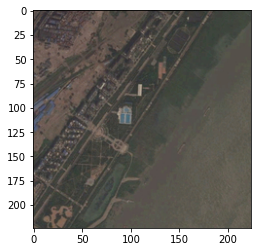

Human-annotated Caption:
 a park with some green plants and buildings is near a piece of water .
Generated Caption:
 many buildings are in two sides of a park with many green trees and an irregular pond .
BLEU score: 0.6042750794713536
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/bridge_306.jpg


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


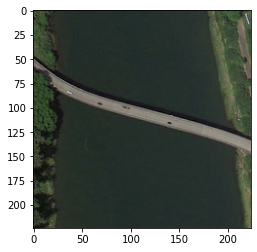

Human-annotated Caption:
 a long bridge is between the two mountains .
Generated Caption:
 a large area of grass is grown on the land .
BLEU score: 0.6865890479690392
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/playground_155.jpg


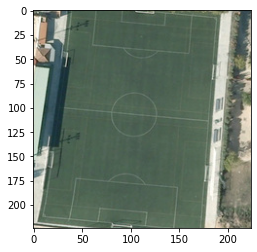

Human-annotated Caption:
 some trees are near a football field .
Generated Caption:
 a football field is near several green trees .
BLEU score: 0.7071067811865476
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/mountain_330.jpg


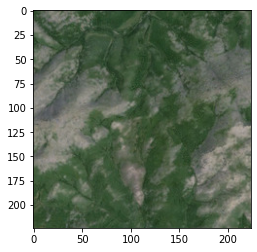

Human-annotated Caption:
 some part of the mountain is covered by vegetations while others are bare .
Generated Caption:
 the of this mountain is very high .
BLEU score: 0.5169731539571706
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/port_121.jpg


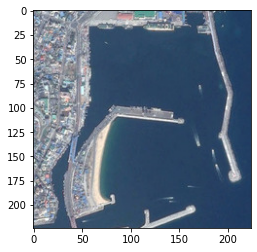

Human-annotated Caption:
 several boats are in a large port near many buildings .
Generated Caption:
 a shaped church with five round green roofs is along the street which are polygonal buildings
BLEU score: 0.5491004867761125
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/mediumresidential_163.jpg


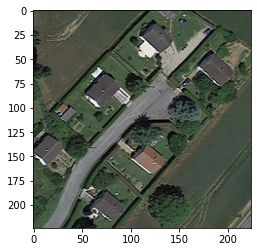

Human-annotated Caption:
 some buildings and many green trees are in a medium residential area .
Generated Caption:
 some buildings and many green trees are in a medium residential area .
BLEU score: 0.6262844962765469
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/pond_185.jpg


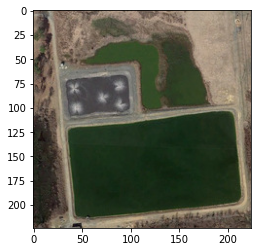

Human-annotated Caption:
 some green trees are near a rectangular pond and two irregular ponds .
Generated Caption:
 a road is near a baseball field .
BLEU score: 0.6262844962765469
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/park_10.jpg


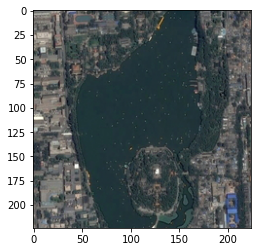

Human-annotated Caption:
 a lake with black water in the middle .
Generated Caption:
 many green trees and some farmlands are in two sides of a river .
BLEU score: 0.6865890479690392
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/beach_14.jpg


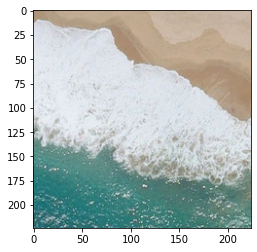

Human-annotated Caption:
 white waves are between green ocean and yellow beach .
Generated Caption:
 a piece of ocean is near a yellow beach and some meadows .
BLEU score: 0.5623413251903491
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/bridge_160.jpg


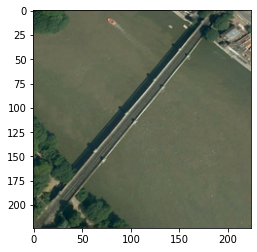

Human-annotated Caption:
 many green trees are in one side of a river with a bridge over it .
Generated Caption:
 a bridge is on a river with some green trees .
BLEU score: 0.5946035575013605
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/river_383.jpg


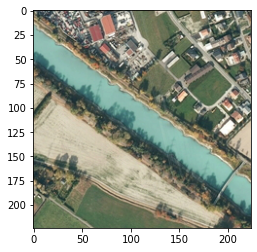

Human-annotated Caption:
 a large number of residential areas on both sides of the river .
Generated Caption:
 some buildings and many green trees are around a gray church .
BLEU score: 0.6262844962765469
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/river_397.jpg


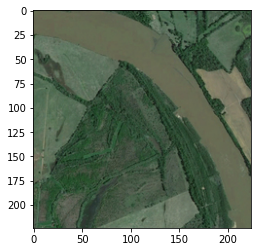

Human-annotated Caption:
 the river is across the farmlands .
Generated Caption:
 there are many green plants in a large field .
BLEU score: 0.6147881529512643
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/center_237.jpg


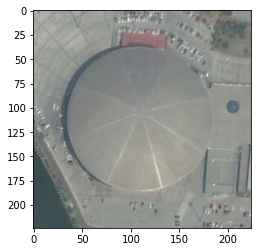

Human-annotated Caption:
 a circle silver gray center with a parking lot is near a river .
Generated Caption:
 several roads and some green trees are around a white circle building .
BLEU score: 0.6147881529512643
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/storagetanks_179.jpg


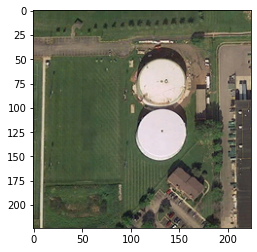

Human-annotated Caption:
 two huge cylindrical buildings occupied most of the position .
Generated Caption:
 several roads and some green trees are around a white circle building .
BLEU score: 0.5623413251903491
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/parking_145.jpg


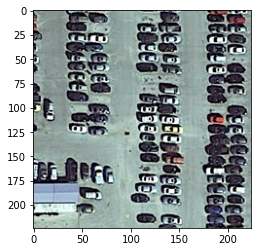

Human-annotated Caption:
 many cars are parked in a parking lot .
Generated Caption:
 many cars in different colors are in a parking lot .
BLEU score: 0.6865890479690392
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/center_75.jpg


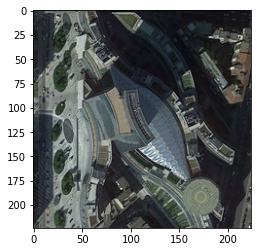

Human-annotated Caption:
 at the corner of a cross there is a series of building whose shapes includes leaf shape arc and triangle  beside which is a square decorated with oval lawns.
Generated Caption:
 many buildings are near a park with many green trees and a pond .
BLEU score: 0.43092381945890607
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/church_46.jpg


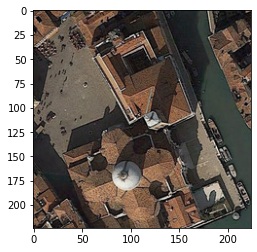

Human-annotated Caption:
 a house with a circular building on the banks of a river .
Generated Caption:
 the roof of the church is blue .
BLEU score: 0.5266403878479265
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/river_359.jpg


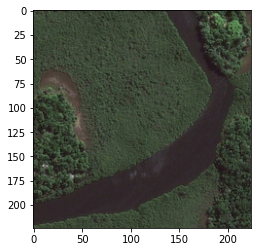

Human-annotated Caption:
 the river is very long and wide .
Generated Caption:
 many green trees are in two sides of a curved river .
BLEU score: 0.5946035575013605
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/industrial_184.jpg


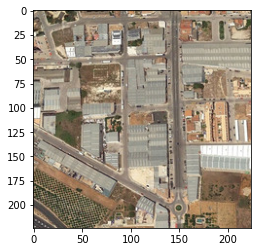

Human-annotated Caption:
 many buildings are in an industrial area .
Generated Caption:
 many buildings are in an industrial area near a dense residential area .
BLEU score: 0.5946035575013605
_____________________________________
/content/drive/My Drive/data/raw/imgs/rsicd/denseresidential_410.jpg


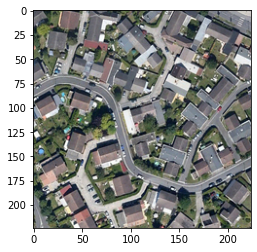

Human-annotated Caption:
 there are some houses with gardens built faced different directions where curved roads are passing through.
Generated Caption:
 many buildings and green trees are in a dense residential area .
BLEU score: 0
_____________________________________


In [145]:
for z in range(20):
  pic = test_img[z]
  image = encoding_test[z]
  print(pic)
  x=plt.imread(pic)
  plt.imshow(x)
  plt.show()
  print("Human-annotated Caption:\n", test_descriptions[z][0])
  generated = generateCaption(image)
  print("Generated Caption:\n", generated)
  print("BLEU score:", 
        bleu_score.sentence_bleu(generated, test_descriptions[z][0].split()))

  print("_____________________________________")

In [0]:
encoding_test[0].shape